In [ ]:
import os
import librosa
import numpy as np
import soundfile
import IPython
import shutil

In [ ]:
import os
import librosa

In [ ]:
# y,sr=librosa.load('test5.mp3')

In [ ]:
count_clean = 0
duration_clean = 0
duration_noise = 0
sample_rate=12000

for i in os.listdir('clean_speech/'):
    count_clean += 1
    y,sr = librosa.load(os.path.join('clean_speech/',i),sr=sample_rate)
    duration = librosa.get_duration(y=y,sr=sr)
    duration_clean+=duration

print(f'Number of clean audio files: {count_clean}')
print(f'Total duration of all clean audios: {duration_clean//60}')

count_noise = 0
for i in os.listdir('noise/'):
    count_noise += 1
    y,sr = librosa.load(os.path.join('noise/',i),sr=sample_rate)
    duration = librosa.get_duration(y=y,sr=sr)
    duration_noise+=duration

print(f'Number of Noisy audio files: {count_noise}')
print(f'Total duration of all noise audios: {duration_noise//60}')

Number of clean audio files are 2703
Total duration of all clean audios 323.0
Number of Noisy audio files are 2009
Total duration of all noise audios 170.0


In [ ]:
import librosa
import numpy as np

In [ ]:
#splitting numpy array into parts and stacking them up into a matrix
def audio_to_audio_frame_stack(audio,frame_length,frame_hop_length):

    frame_stack_list=[]
    audio_length=audio.shape[0]
    for i in range(0,audio_length-frame_length+1,frame_hop_length):
        frame_stack_list.append(audio[i:i+frame_length])

    return np.vstack(frame_stack_list)


In [ ]:
#mixing clean and noisy audio
def blend_noise_randomly(clean_audio,noise,n_samples,frame_length):

    res_clean_audio=np.zeros((n_samples,frame_length))
    res_noise=np.zeros((n_samples,frame_length))
    res_noisy_audio=np.zeros((n_samples,frame_length))

    for i in range(n_samples):
        clean_audio_id=np.random.randint(0,clean_audio.shape[0])
        noise_id=np.random.randint(0,noise.shape[0])A
        intensity=np.random.uniform(0.2,0.8)
        res_clean_audio[i]=clean_audio[clean_audio_id,:]
        res_noise[i]=intensity*noise[noise_id,:]
        res_noisy_audio[i]=res_clean_audio[i]+res_noise[i]

    return res_clean_audio,res_noise,res_noisy_audio

In [ ]:
#applying stft on a row from audio and returning magnitude and phase
def audio_to_magnitude_db_and_phase(n_fft,hop_length_fft,audio):

    stft_audio=librosa.stft(audio,n_fft=n_fft,hop_length=hop_length_fft)
    stft_audio_magnitude,stft_audio_phase=librosa.magphase(stft_audio)

    stft_audio_magnitude_db=librosa.amplitude_to_db(stft_audio_magnitude,ref=np.max)
    return stft_audio_magnitude_db,stft_audio_phase

In [ ]:
def audio_file_to_numpy(audio_path,sample_rate,frame_length, hop_length_frame,min_duration):

    y,sr=librosa.load(audio_path,sr=sample_rate)

#         total_duration=librosa.get_duration(y=y,sr=sr)
#         if(total_duration>=min_duration):
#             list_audio_arrays.append(audio_to_audio_frame_stack(y,sample_rate,hop_length_frame))
    return np.vstack(audio_to_audio_frame_stack(y,frame_length,hop_length_frame))

In [ ]:
#combining all the audio files from the audio_dir directory into a matrix
def audio_files_to_numpy(audio_dir,sample_rate,frame_length, hop_length_frame,min_duration):
    audio_file_list=os.listdir(audio_dir)
    list_audio_arrays=[]
    i=0
    for file in audio_file_list:
        i=i+1
        y,sr=librosa.load(os.path.join(audio_dir,file),sr=sample_rate)
        # print(y.shape)
        total_duration=librosa.get_duration(y=y,sr=sr)
        if(total_duration>=min_duration):
            list_audio_arrays.append(audio_to_audio_frame_stack(y,frame_length,hop_length_frame))
    print(i)
    return np.vstack(list_audio_arrays)


In [ ]:
#creating final matrix by applying atft on every row of audio matrix
def numpy_audio_to_matrix_spectrogram(numpy_audio, dim_square_spec, n_fft, hop_length_fft):
    dim=int(n_fft/2)+1
    tot_rows=numpy_audio.shape[0]
#     print(type(dim))
#     print(type(tot_rows))
    mag_matrix=np.zeros((tot_rows,dim,dim))
    phase_matrix=np.zeros((tot_rows,dim,dim),dtype=complex)
    for i in range (tot_rows):
        mag_matrix[i],phase_matrix[i]=audio_to_magnitude_db_and_phase(n_fft, hop_length_fft, numpy_audio[i])
    return mag_matrix,phase_matrix

In [ ]:
#creating data
def create_data(noise_dir, voice_dir,path_save_spectrogram, sample_rate,
min_duration, frame_length, hop_length_frame, hop_length_frame_noise, nb_samples, n_fft, hop_length_fft):

    dim_square_spec=0

    noise=audio_files_to_numpy(noise_dir,sample_rate,frame_length, hop_length_frame_noise,min_duration)
    print(noise.shape)
    voice=audio_files_to_numpy(voice_dir,sample_rate,frame_length,hop_length_frame,min_duration)
    print(voice.shape)
#     voice_vstack=audio_to_audio_frame_stack(voice,frame_length,hop_length_frame)
#     noise_vstack=audio_to_audio_frame_stack(noise,frame_length,hop_length_frame_noise)

    res_voice,res_noise,res_mixed=blend_noise_randomly(voice,noise,nb_samples,frame_length)#n_samples

    voice_amp_matrix,voice_phase_matrix=numpy_audio_to_matrix_spectrogram(res_voice, dim_square_spec, n_fft, hop_length_fft)
    noise_amp_matrix,noise_phase_matrix=numpy_audio_to_matrix_spectrogram(res_noise, dim_square_spec, n_fft, hop_length_fft)
    mixed_amp_matrix,mixed_phase_matrix=numpy_audio_to_matrix_spectrogram(res_mixed, dim_square_spec, n_fft, hop_length_fft)

    np.save(path_save_spectrogram + 'voice_amp_db', voice_amp_matrix)
    np.save(path_save_spectrogram + 'noise_amp_db', noise_amp_matrix)             #Not required
    np.save(path_save_spectrogram + 'noisy_voice_amp_db', mixed_amp_matrix)
    print("done")

In [ ]:
!mkdir spectogram

mkdir: cannot create directory ‘spectogram’: File exists


In [ ]:
noise_dir="noise/"
voice_dir="clean_speech/"
path_save_spectrogram="spectogram/"
sample_rate=16000
min_duration=1.0
frame_length=8064
hop_length_frame=16064
hop_length_frame_noise=16064
nb_samples=5000
n_fft=255
hop_length_fft=63

In [ ]:
noise=audio_files_to_numpy("verification_set/",sample_rate,frame_length, hop_length_frame_noise,min_duration)

(70400,)
(80000,)
(108800,)
(80000,)
(80000,)
(80000,)
(80000,)
(33440,)
(219040,)
(80000,)
(80000,)
(63840,)
12


In [ ]:
noise.shape

(122, 8064)

In [ ]:
noise=audio_files_to_numpy(noise_dir,sample_rate,frame_length, hop_length_frame_noise,min_duration)
print(noise.shape)
voice=audio_files_to_numpy(voice_dir,sample_rate,frame_length,hop_length_frame,min_duration)
print(voice.shape)

2000
(18000, 8064)
2703
(37123, 8064)


In [ ]:
noise=np.zeros((1,1))
voice=np.zeros((1,1))

In [ ]:
create_data(noise_dir=noise_dir,voice_dir=voice_dir,
            path_save_spectrogram=path_save_spectrogram,
            sample_rate=sample_rate,min_duration=min_duration,frame_length=frame_length,hop_length_frame=hop_length_frame,hop_length_frame_noise=hop_length_frame_noise,nb_samples=nb_samples,n_fft=n_fft,hop_length_fft=hop_length_fft)

2000
(18000, 8064)
2703
(37123, 8064)
done


In [ ]:
noisy_voice_amp_db = np.load('spectogram/noisy_voice_amp_db.npy')
print(np.shape(noisy_voice_amp_db))

In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
import tensorflow as tf
# print(tf.__version__)

#Unet network
def unet(input_size = (128,128,1)):
    #size filter input
    size_filter_in = 16
    #normal initialization of weights
    kernel_init = 'he_normal'
    #To apply leaky relu after the conv layer
    activation_layer = None
    inputs = Input(input_size)
    conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(inputs)
    conv1 = LeakyReLU()(conv1)
    conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv1)
    conv1 = LeakyReLU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool1)
    conv2 = LeakyReLU()(conv2)
    conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv2)
    conv2 = LeakyReLU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool2)
    conv3 = LeakyReLU()(conv3)
    conv3 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv3)
    conv3 = LeakyReLU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool3)
    conv4 = LeakyReLU()(conv4)
    conv4 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv4)
    conv4 = LeakyReLU()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool4)
    conv5 = LeakyReLU()(conv5)
    conv5 = Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv5)
    conv5 = LeakyReLU()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(size_filter_in*8, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(drop5))
    up6 = LeakyReLU()(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge6)
    conv6 = LeakyReLU()(conv6)
    conv6 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv6)
    conv6 = LeakyReLU()(conv6)
    up7 = Conv2D(size_filter_in*4, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv6))
    up7 = LeakyReLU()(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge7)
    conv7 = LeakyReLU()(conv7)
    conv7 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv7)
    conv7 = LeakyReLU()(conv7)
    up8 = Conv2D(size_filter_in*2, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv7))
    up8 = LeakyReLU()(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge8)
    conv8 = LeakyReLU()(conv8)
    conv8 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv8)
    conv8 = LeakyReLU()(conv8)

    up9 = Conv2D(size_filter_in, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv8))
    up9 = LeakyReLU()(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
    conv9 = LeakyReLU()(conv9)
    conv10 = Conv2D(1, 1, activation = 'tanh')(conv9)

    model = Model(inputs,conv10)

    model.compile(optimizer = 'adam', loss = tf.keras.losses.MeanSquaredError(), metrics = ['mae'])
    #model.summary()
    return model

In [ ]:
def scaled_in(matrix_spec):
    "global scaling apply to noisy voice spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec + 46)/50
    return matrix_spec
def scaled_ou(matrix_spec):
    "global scaling apply to noise models spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec -6 )/82
    return matrix_spec

In [ ]:
noisy_voice = np.load("spectogram/noisy_voice_amp_db.npy")
voice = np.load("spectogram/voice_amp_db.npy")
noise = noisy_voice-voice
# Shape of noisy voice data
print(noisy_voice.shape)
# Shape of noise data
print(noise.shape)

(5000, 128, 128)
(5000, 128, 128)


In [ ]:
# Input
noisy_voice = noisy_voice[:,:,:]
noisy_voice = noisy_voice.reshape(noisy_voice.shape[0],noisy_voice.shape[1],noisy_voice.shape[2],1)
# Output
noise = noise[:,:,:]
noise = noise.reshape(noise.shape[0],noise.shape[1],noise.shape[2],1)
# Shapes after reshaping
print(noisy_voice.shape)
print(noise.shape)

(5000, 128, 128, 1)
(5000, 128, 128, 1)


In [ ]:
import matplotlib.pyplot as plt
import pandas
from tensorflow.keras.models import model_from_json
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def training_unet(path_save_spectrogram, weights_path, epochs, batch_size):
    """ This function will read noisy voice and clean voice spectrograms created by data_creation mode,
    and train a Unet model on this dataset for epochs and batch_size specified. It saves best models to disk regularly.
    """
    #load noisy voice & clean voice spectrograms created by data_creation mode
    X_in = np.load(path_save_spectrogram +'noisy_voice_amp_db'+".npy")
    X_ou = np.load(path_save_spectrogram +'voice_amp_db'+".npy")
    #Model of noise to predict
    X_ou = X_in - X_ou

    #Check distribution
    print(stats.describe(X_in.reshape(-1,1)))
    print(stats.describe(X_ou.reshape(-1,1)))

    #to scale between -1 and 1
    X_in = scaled_in(X_in)
    X_ou = scaled_ou(X_ou)

    #Check shape of spectrograms
    print(X_in.shape)
    print(X_ou.shape)
    #Check new distribution
    print(stats.describe(X_in.reshape(-1,1)))
    print(stats.describe(X_ou.reshape(-1,1)))


    #Reshape for training
    X_in = X_in[:,:,:]
    X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)
    X_ou = X_ou[:,:,:]
    X_ou = X_ou.reshape(X_ou.shape[0],X_ou.shape[1],X_ou.shape[2],1)
    # print(X_in.shape)
    # print(X_out.shape)

    X_train, X_test, y_train, y_test = train_test_split(X_in, X_ou, test_size=0.10, random_state=42)

    generator_nn=unet()

    #Save best models to disk during training
    checkpoint = ModelCheckpoint(weights_path+'/model_unet_best.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

    generator_nn.summary()

    #Training
    history = generator_nn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[checkpoint], verbose=1, validation_data=(X_test, y_test))
    model_in_json = generator_nn.to_json()

    #Saving Model
    with open(weights_path+'/model_unet.json','w') as json_file:
        json_file.write(model_in_json)

    #Plot training and validation loss (log scale)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.yscale('log')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [ ]:
!mkdir weights

mkdir: cannot create directory ‘weights’: File exists


DescribeResult(nobs=81920000, minmax=(array([-80.]), array([0.])), mean=array([-46.42524384]), variance=array([298.01548293]), skewness=array([0.03174837]), kurtosis=array([-0.57155687]))
DescribeResult(nobs=81920000, minmax=(array([-80.]), array([80.])), mean=array([6.52047698]), variance=array([185.08754034]), skewness=array([1.11932757]), kurtosis=array([1.77049761]))
(5000, 128, 128)
(5000, 128, 128)
DescribeResult(nobs=81920000, minmax=(array([-0.68]), array([0.92])), mean=array([-0.00850488]), variance=array([0.11920619]), skewness=array([0.03174837]), kurtosis=array([-0.57155687]))
DescribeResult(nobs=81920000, minmax=(array([-1.04878049]), array([0.90243902])), mean=array([0.00634728]), variance=array([0.0275264]), skewness=array([1.11932757]), kurtosis=array([1.77049761]))
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to             

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


450/450 [==============================] - 37s 42ms/step - loss: 0.0229 - mae: 0.1103 - val_loss: 0.0186 - val_mae: 0.0971
Epoch 2/20
449/450 [============================>.] - ETA: 0s - loss: 0.0172 - mae: 0.0934
Epoch 2: val_loss improved from 0.01860 to 0.01731, saving model to ./weights/model_unet_best.h5
450/450 [==============================] - 18s 41ms/step - loss: 0.0172 - mae: 0.0934 - val_loss: 0.0173 - val_mae: 0.1019
Epoch 3/20
450/450 [==============================] - ETA: 0s - loss: 0.0154 - mae: 0.0866
Epoch 3: val_loss improved from 0.01731 to 0.01694, saving model to ./weights/model_unet_best.h5
450/450 [==============================] - 19s 42ms/step - loss: 0.0154 - mae: 0.0866 - val_loss: 0.0169 - val_mae: 0.0979
Epoch 4/20
449/450 [============================>.] - ETA: 0s - loss: 0.0147 - mae: 0.0839
Epoch 4: val_loss improved from 0.01694 to 0.01413, saving model to ./weights/model_unet_best.h5
450/450 [==============================] - 19s 41ms/step - loss: 0.

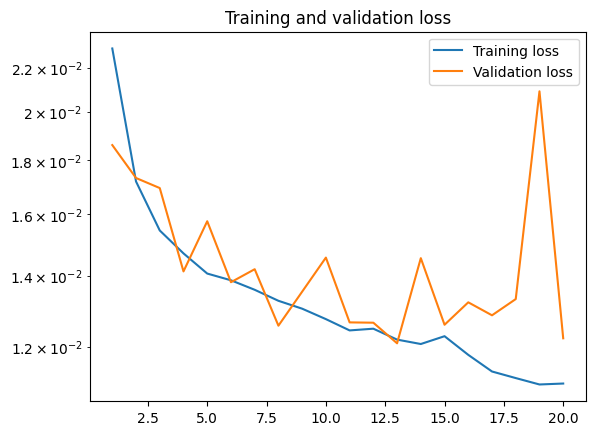

In [ ]:
training_unet(path_save_spectrogram, './weights', epochs=  20,batch_size=10)

In [ ]:
#Helper Functions
def magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, stftaudio_magnitude_db, stftaudio_phase):
    """This functions reverts a spectrogram to an audio"""

    stftaudio_magnitude_rev = librosa.db_to_amplitude(stftaudio_magnitude_db, ref=1.0)

    # taking magnitude and phase of audio
    audio_reverse_stft = stftaudio_magnitude_rev * stftaudio_phase
    audio_reconstruct = librosa.core.istft(audio_reverse_stft, hop_length=hop_length_fft, length=frame_length)

    return audio_reconstruct


def matrix_spectrogram_to_numpy_audio(m_mag_db, m_phase, frame_length, hop_length_fft)  :
    """This functions reverts the matrix spectrograms to numpy audio"""

    list_audio = []

    nb_spec = m_mag_db.shape[0]

    for i in range(nb_spec):

        audio_reconstruct = magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, m_mag_db[i], m_phase[i])
        list_audio.append(audio_reconstruct)

    return np.vstack(list_audio)

def inv_scaled_ou(matrix_spec):
    "inverse global scaling apply to noise models spectrograms"
    matrix_spec = matrix_spec * 82 + 6
    return matrix_spec


In [ ]:
import librosa
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import model_from_json
import soundfile as sf

def prediction(weights_path,  dir_save_prediction, audio_input_for_prediction,
audio_output_prediction):
    """ This function takes as input pretrained weights, noisy voice sound to denoise, predict
    the denoise sound and save it to disk.
    """

    # load json and create model
    json_file = open(weights_path+'/model_unet.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model/
    loaded_model.load_weights(weights_path+'/model_unet_best.h5')
    print("Loaded model from disk")


#     audio_dir,sample_rate,frame_length, hop_length_frame,min_duration
    # Extracting noise and voice from folder and convert to numpy
    audio = audio_file_to_numpy(audio_input_for_prediction, sample_rate,
                                 frame_length, hop_length_frame, min_duration)

    #Dimensions of squared spectrogram
    dim_square_spec = int(n_fft / 2) + 1
    print(dim_square_spec)

    # Create Amplitude and phase of the sounds
    m_amp_db_audio,  m_pha_audio = numpy_audio_to_matrix_spectrogram(
        audio, dim_square_spec, n_fft, hop_length_fft)

    #global scaling to have distribution -1/1
    X_in = scaled_in(m_amp_db_audio)
    #Reshape for prediction
    X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)
    #Prediction using loaded network
    X_pred = loaded_model.predict(X_in)
    #Rescale back the noise model
    inv_sca_X_pred = inv_scaled_ou(X_pred)
    #Remove noise model from noisy speech
    X_denoise = m_amp_db_audio - inv_sca_X_pred[:,:,:,0]
    #Reconstruct audio from denoised spectrogram and phase
    print(X_denoise.shape)
    print(m_pha_audio.shape)
    print(frame_length)
    print(hop_length_fft)
    audio_denoise_recons = matrix_spectrogram_to_numpy_audio(X_denoise, m_pha_audio, frame_length, hop_length_fft)
    #Number of frames
    nb_samples = audio_denoise_recons.shape[0]
    #Save all frames in one file
    denoise_long = audio_denoise_recons.reshape(1, nb_samples * frame_length)*10
    # librosa.output.write_wav(dir_save_prediction + audio_output_prediction, denoise_long[0, :], 1000)
    sf.write(dir_save_prediction + audio_output_prediction, denoise_long[0, :], 16000, 'PCM_24')
    # wavfile.write(dir_save_prediction + audio_output_prediction, 1000, denoise_long[0,:])
    print("done")

In [ ]:
def amplify(path):
    song = AudioSegment.from_wav(song)
  # Increase volume of the audio by 10 decibels
    louder = song+10
    louder.export(path+".wav")

In [ ]:
# weights_path,  dir_save_prediction, audio_input_for_prediction,
# audio_output_prediction

In [ ]:
audio_input_for_prediction='test6'

In [ ]:
prediction('weights', '',  audio_input_for_prediction+'.wav',
        audio_input_for_prediction+'_denoised.wav')

Loaded model from disk
128
1/1 [==============================] - 0s 277ms/step
(8, 128, 128)
(8, 128, 128)
8064
63
done


In [ ]:
from IPython.display import Audio
Audio(audio_input_for_prediction+'.wav')

In [ ]:
Audio(audio_input_for_prediction+'_denoised.wav')

## neural network

# cnn

In [ ]:
t=np.zeros((1,2,2))

In [ ]:
print(t)

[[[0. 0.]
  [0. 0.]]]


In [ ]:
a=3.0
b=int(a/2)+1


In [ ]:
type(b)

int

In [ ]:
y,sr=librosa.load('test7.wav',sr=22000)

In [ ]:
print(sr)

22000


In [ ]:
print(y.shape)

(175824,)


In [ ]:
arr=np.zeros((16000,8064),dtype='float')

In [ ]:
# arr=arr.vstack(arr)

In [ ]:
print(arr)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
del arr

In [ ]:
# arr